# Predicting Las Vegas Grand Prix outcomes with Machine Learning

We will predict the likely outcome of the qualifying session and the race. This will guide us through the EDA.

## Setup

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Exploration of the dataset

In [9]:
# Load the dataset in a dataframe
df = pd.read_csv('0_f1_master_database.csv')

# Quick look at the dataframe
df.head()

,DriverNumber,Driver,Team,GridPosition,Q1_time,Q2_time,Q3_time,Best_Quali_Time,FP1_AvgLapTime,FP1_StdLapTime,...,FP3_LapCount,FP3_AvgSpeedI1,FP3_AvgSpeedI2,FP3_AvgSpeedFL,FP3_AvgSpeedST,RacePosition,RaceTime,Status,Year,Event
0,1,VER,Red Bull Racing,1.0,90.031,89.374,89.179,89.179,107.957133,18.665004,...,12.0,191.416667,221.083333,251.111111,236.833333,1.0,5504.742,Finished,2024,Bahrain Grand Prix
1,16,LEC,Ferrari,2.0,90.243,89.165,89.407,89.165,109.744000,16.984436,...,14.0,198.642857,217.500000,261.900000,265.571429,4.0,39.669,Finished,2024,Bahrain Grand Prix
2,63,RUS,Mercedes,3.0,90.350,89.922,89.485,89.485,110.281700,19.378515,...,7.0,211.285714,226.571429,283.000000,246.714286,5.0,46.788,Finished,2024,Bahrain Grand Prix
3,55,SAI,Ferrari,4.0,89.909,89.573,89.507,89.507,109.881850,16.987946,...,13.0,210.230769,221.153846,238.111111,244.538462,3.0,25.110,Finished,2024,Bahrain Grand Prix
4,11,PER,Red Bull Racing,5.0,90.221,89.932,89.537,89.537,112.015777,21.985955,...,11.0,197.200000,220.909091,251.714286,238.454545,2.0,22.457,Finished,2024,Bahrain Grand Prix


In [10]:
# Jack Doohan ('DOO') is part of the 2025 drivers but won't be racing in Las Vegas. 
# We can remove his data from the dataset
df = df[df['Driver'] != 'DOO'].copy()

In [11]:
# We can remove the 'GridPosition' column because it will depend on our target feature (predicted qualifying time)
df = df.drop('GridPosition', axis= 1)

In [14]:
# Fix the RaceTime data so every value is the actual race time of the driver (not the gap to the winner)

df_fixed = df.copy()

# Check the race 'Status' ('Finished': we have the driver's actual time / 'Lapped': driver is missing last lap)
print("Race Status breakdown:")
status_counts = df_fixed['Status'].value_counts()
print(status_counts)

print(f"\nTotal rows: {len(df_fixed)}")
print(f"Finished races: {(df_fixed['Status'] == 'Finished').sum()}")
print(f"Lapped drivers: {(df_fixed['Status'] == 'Lapped').sum()}")
print(f"DNF: {(df_fixed['Status'] == 'DNF').sum()}")
print(f"DNS: {(df_fixed['Status'] == 'DNS').sum()}\n")

def fix_race_times_with_lapped(group):
    """
    For a single race:
    - Finished drivers: RaceTime is gap → add winner's time
    - Lapped drivers: RaceTime is gap → add winner's time + FP1_AvgLapTime (to adjust as best as possible the prediction)
    - DNF/DNS: Keep as is (no finish time)
    """
    
    # Find the winner's actual RaceTime (maximum value for Finished drivers because only one to have a RaceTime > 1hr)
    finished_drivers = group[group['Status'] == 'Finished']
    
    winner_time = finished_drivers['RaceTime'].max() 
    
    # Process each row
    for idx in group.index:
        status = group.loc[idx, 'Status']
        current_time = group.loc[idx, 'RaceTime']
        
        if status == 'Finished':
            # For finished drivers: add winner's time to the gap
            if current_time == winner_time:
                # This is the winner, keep as is
                group.loc[idx, 'RaceTime'] = winner_time
            else:
                # Gap + winner's time = actual finish time
                group.loc[idx, 'RaceTime'] = winner_time + current_time
        
        elif status == 'Lapped':
            # For lapped drivers: add winner's time + one lap time
            lap_time = group.loc[idx, 'FP1_AvgLapTime']
            
            # If no FP1_AvgLapTime available, estimate from other drivers' lap times
            if pd.isna(lap_time) or lap_time == 0:
                # Use average FP1_AvgLapTime from this race
                lap_time = group['FP1_AvgLapTime'].mean()
            
            # If still no lap time, use overall average
            if pd.isna(lap_time) or lap_time == 0:
                lap_time = df[df['FP1_AvgLapTime'] > 0]['FP1_AvgLapTime'].mean()
            
            group.loc[idx, 'RaceTime'] = winner_time + current_time + lap_time
        
        # DNF and DNS: keep RaceTime as is (they didn't finish)
    
    return group

Race Status breakdown:
Status
Finished         572
Lapped           216
Retired           91
Did not start      6
Disqualified       6
Name: count, dtype: int64

Total rows: 891
Finished races: 572
Lapped drivers: 216
DNF: 0
DNS: 0



In [15]:
# Apply the fix for each race
print("Processing races...\n")
df_fixed = df_fixed.groupby(['Event', 'Year'], group_keys=False).apply(fix_race_times_with_lapped)

# Replace original dataframe
df = df_fixed

print("✅ RaceTime values corrected!")

Processing races...

✅ RaceTime values corrected!


/var/folders/r2/1ym4v4yx6v541qn4vt1csn5r0000gn/T/ipykernel_93279/3113140498.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_fixed = df_fixed.groupby(['Event', 'Year'], group_keys=False).apply(fix_race_times_with_lapped)


In [16]:
# Updated datastet description
df.describe()

,DriverNumber,Q1_time,Q2_time,Q3_time,Best_Quali_Time,FP1_AvgLapTime,FP1_StdLapTime,FP1_BestLapTime,FP1_LapCount,FP1_AvgSpeedI1,...,FP3_StdLapTime,FP3_BestLapTime,FP3_LapCount,FP3_AvgSpeedI1,FP3_AvgSpeedI2,FP3_AvgSpeedFL,FP3_AvgSpeedST,RacePosition,RaceTime,Year
count,891.000000,878.000000,661.000000,442.000000,880.000000,825.000000,822.000000,825.000000,825.000000,825.000000,...,631.000000,646.000000,646.000000,645.000000,646.000000,644.000000,645.000000,891.000000,787.000000,891.000000
mean,28.957351,83.815263,83.063690,82.636165,83.290881,102.480121,18.857197,85.176286,18.518788,233.843477,...,20.352533,84.142057,13.534056,231.839282,232.459279,255.819583,265.715973,10.434343,5639.736497,2024.463524
std,24.029298,11.025171,10.867523,10.868616,10.980067,9.187440,4.334582,10.854607,6.163622,38.517012,...,5.158202,12.560000,5.800394,37.544643,37.496319,31.800657,22.569889,5.755008,722.614031,0.498948
min,1.000000,64.672000,64.410000,63.971000,63.971000,80.757971,3.239936,65.542000,1.000000,148.500000,...,0.675994,64.324000,1.000000,144.166667,134.000000,78.000000,89.000000,1.000000,4404.325000,2024.000000
25%,11.000000,75.517750,75.176000,74.714500,74.816750,95.133478,16.488719,75.635000,15.000000,201.500000,...,18.030957,75.137250,10.000000,204.692308,208.516544,233.994147,250.700000,5.000000,5150.516244,2024.000000
50%,22.000000,83.680000,83.199000,82.814000,83.234000,103.236235,19.266334,86.754000,18.000000,240.400000,...,20.887188,80.529500,13.000000,235.333333,235.325000,255.058824,266.076923,10.000000,5577.362000,2024.000000
75%,44.000000,90.992750,90.054000,89.686750,90.435750,109.647705,21.768754,93.123000,22.000000,261.037037,...,23.803345,90.908250,17.000000,261.400000,260.068182,277.582692,281.437500,15.000000,5924.358500,2025.000000
max,87.000000,117.775000,115.716000,114.810000,117.775000,125.287545,30.338427,117.029000,35.000000,327.416667,...,35.458342,147.994000,30.000000,306.500000,325.000000,339.400000,314.888889,20.000000,8747.673000,2025.000000


In [17]:
# Updated dataset shape
df.shape

(891, 36)

In [18]:
# Dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 0 to 897
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DriverNumber     891 non-null    int64  
 1   Driver           891 non-null    object 
 2   Team             891 non-null    object 
 3   Q1_time          878 non-null    float64
 4   Q2_time          661 non-null    float64
 5   Q3_time          442 non-null    float64
 6   Best_Quali_Time  880 non-null    float64
 7   FP1_AvgLapTime   825 non-null    float64
 8   FP1_StdLapTime   822 non-null    float64
 9   FP1_BestLapTime  825 non-null    float64
 10  FP1_LapCount     825 non-null    float64
 11  FP1_AvgSpeedI1   825 non-null    float64
 12  FP1_AvgSpeedI2   825 non-null    float64
 13  FP1_AvgSpeedFL   824 non-null    float64
 14  FP1_AvgSpeedST   825 non-null    float64
 15  FP2_AvgLapTime   638 non-null    float64
 16  FP2_StdLapTime   634 non-null    float64
 17  FP2_BestLapTime  638 

In [19]:
# Missing values in the dataset
"""
Missing values in Q2 and Q3 are normal because of the format of the qualifying session.
Missing values in FP2 and FP3 are normal because some Grand Prix have a sprint race, and only one FP session
Other missing values are due to incidents in the sessions (car retirement, disqualification, etc.)
"""

print("Missing values:")
df.isnull().sum()

Missing values:


DriverNumber         0
Driver               0
Team                 0
Q1_time             13
Q2_time            230
Q3_time            449
Best_Quali_Time     11
FP1_AvgLapTime      66
FP1_StdLapTime      69
FP1_BestLapTime     66
FP1_LapCount        66
FP1_AvgSpeedI1      66
FP1_AvgSpeedI2      66
FP1_AvgSpeedFL      67
FP1_AvgSpeedST      66
FP2_AvgLapTime     253
FP2_StdLapTime     257
FP2_BestLapTime    253
FP2_LapCount       253
FP2_AvgSpeedI1     253
FP2_AvgSpeedI2     253
FP2_AvgSpeedFL     254
FP2_AvgSpeedST     253
FP3_AvgLapTime     245
FP3_StdLapTime     260
FP3_BestLapTime    245
FP3_LapCount       245
FP3_AvgSpeedI1     246
FP3_AvgSpeedI2     245
FP3_AvgSpeedFL     247
FP3_AvgSpeedST     246
RacePosition         0
RaceTime           104
Status               0
Year                 0
Event                0
dtype: int64

In [25]:
# Save updated df to a new csv
df.to_csv('0_Updated_f1_master_database.csv')

### Specific exploration: Qualifying Data
This shows the overall tendencies of qualifying sessions. However, not all circuits are the same and external factors impact a lot the data.

In [20]:
# missing qualifying data (in %)
quali_cols = ['Q1_time', 'Q2_time', 'Q3_time', 'Best_Quali_Time']
print(f"Missing Qualifying Data:")
for col in quali_cols:
    missing_pct = (df[col].isnull().sum() / len(df)) * 100
    print(f"  {col}: {missing_pct:.1f}%")

# stats for best qualifying times
print(f"\nBest_Quali_Time Stats:")
print(df['Best_Quali_Time'].describe())

Missing Qualifying Data:
  Q1_time: 1.5%
  Q2_time: 25.8%
  Q3_time: 50.4%
  Best_Quali_Time: 1.2%

Best_Quali_Time Stats:
count    880.000000
mean      83.290881
std       10.980067
min       63.971000
25%       74.816750
50%       83.234000
75%       90.435750
max      117.775000
Name: Best_Quali_Time, dtype: float64


/var/folders/r2/1ym4v4yx6v541qn4vt1csn5r0000gn/T/ipykernel_93279/3043952124.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=years)


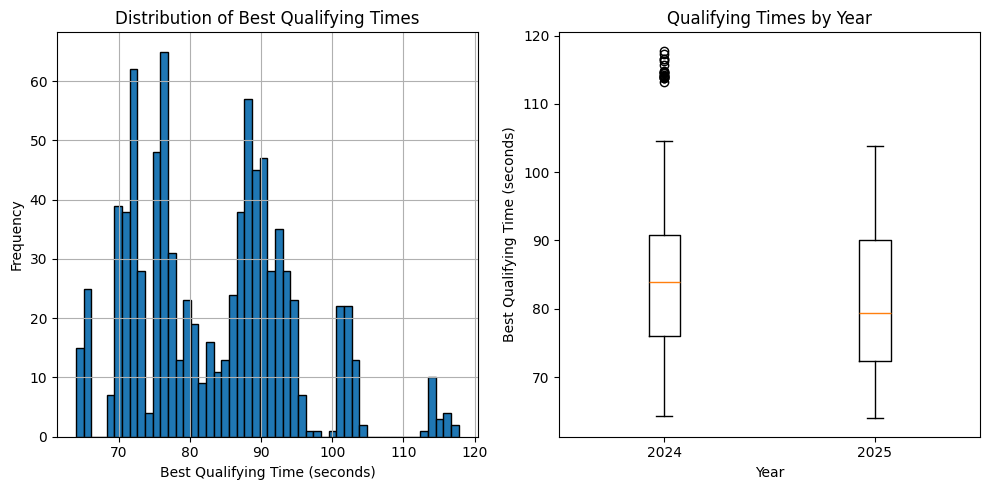

In [21]:
# Best_Quali_Time distribution
plt.figure(figsize=(10, 5))

# Histogram
plt.subplot(1, 2, 1)
df['Best_Quali_Time'].hist(bins=50, edgecolor='black')
plt.xlabel('Best Qualifying Time (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Best Qualifying Times')

# Boxplot by year
plt.subplot(1, 2, 2)
years = sorted(df['Year'].unique())
boxplot_data = [df[df['Year'] == year]['Best_Quali_Time'].dropna() for year in years]
plt.boxplot(boxplot_data, labels=years) 
plt.xlabel('Year')
plt.ylabel('Best Qualifying Time (seconds)')
plt.title('Qualifying Times by Year')

plt.tight_layout()
plt.show()

### Specific exploration: Race Data

In [26]:
# stats for RaceTime
print(f"RaceTime Stats:")
print(df['RaceTime'].describe())

RaceTime Stats:
count     787.000000
mean     5639.736497
std       722.614031
min      4404.325000
25%      5150.516244
50%      5577.362000
75%      5924.358500
max      8747.673000
Name: RaceTime, dtype: float64


/var/folders/r2/1ym4v4yx6v541qn4vt1csn5r0000gn/T/ipykernel_93279/279819951.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=years)


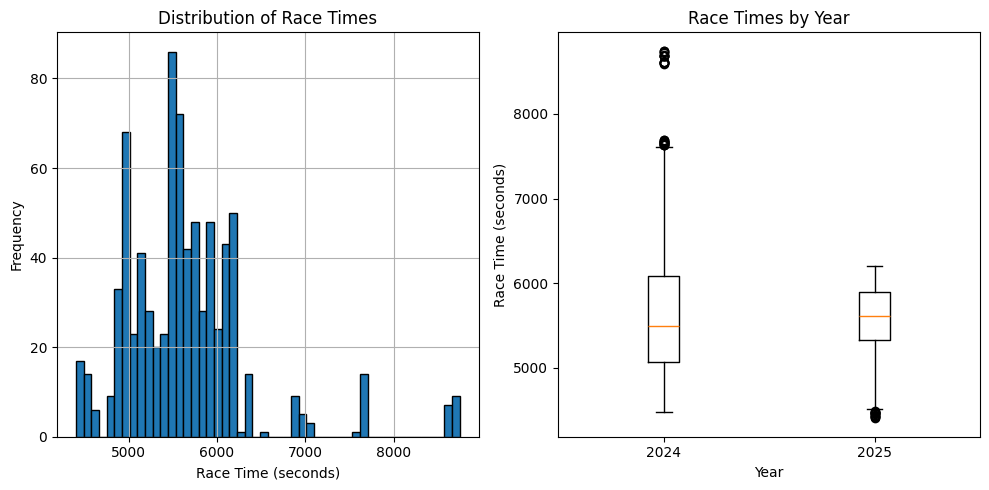

In [ ]:
# RaceTime distribution
plt.figure(figsize=(10, 5))

# Histogram
plt.subplot(1, 2, 1)
df['RaceTime'].hist(bins=50, edgecolor='black')
plt.xlabel('Race Time (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Race Times')

# Boxplot by year
plt.subplot(1, 2, 2)
years = sorted(df['Year'].unique())
boxplot_data = [df[df['Year'] == year]['RaceTime'].dropna() for year in years]
plt.boxplot(boxplot_data, labels=years) 
plt.xlabel('Year')
plt.ylabel('Race Time (seconds)')
plt.title('Race Times by Year')

plt.tight_layout()
plt.show()